# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [3]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts
# !pip install category-encoders
# !pip install mlxtend==0.17.3 # makes Google Colab asking for reboot
# !pip install ppscore

In [4]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [5]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [6]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [7]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [8]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

     |████████████████████████████████| 133kB 2.7MB/s 
     |████████████████████████████████| 6.5MB 5.6MB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 143kB 40.9MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 1.3MB 45.6MB/s 
     |████████████████████████████████| 1.6MB 44.9MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 153kB 57.9MB/s 
  Created wheel for featuretools: filename=featuretools-0.4.1-cp36-none-any.whl size=168821 sha256=f9acdeb1321adef32908a115c8d7e35ce75d90f56c70bf854ace2aad8a723fef
  Stored in directory: /root/.cache/pip/wheels/5e/b4/a0/0ab77ecad651fd33f8aac20d7c5d02a393f774a7eafb34f49c
  Created wheel for gTTS-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4096 sha256=67e0be9a537870dc15052743ef1923c0

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importation of modules and packages. 

In [9]:
import io

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

import missingno as msno
import ppscore as pps

import dill

Setting pandas display options

In [10]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 100,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [11]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [12]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

We load in a dataframe the dataset of aggregated orders obtained from "P5_Cleaning_1.ipynb".

In [13]:
# from datetime import strptime

if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


In [14]:
df_orders.dtypes

customer_unique_id           object
cust_region                  object
order_status                 object
order_purchase_timestamp     object
order_item_nb               float64
product_volume_cm3          float64
product_weight_g            float64
mean_prod_descr_length      float64
shipping_time                object
shipping_delay               object
max_limit_ship_date          object
delivered                     int64
price                       float64
freight_value               float64
review_score                float64
review_comment_length       float64
payment_installments        float64
payment_value               float64
paytype_boleto              float64
paytype_credit_card         float64
paytype_debit_card          float64
paytype_not_defined         float64
paytype_voucher             float64
cat_home                    float64
cat_furniture               float64
cat_electronics             float64
cat_office                  float64
cat_diy                     

In [15]:
speak('Dataset successfully imported')

## 1 Building the Customer dataset

Let's now aggregate all the orders to get a dataset of the customers.

### 1.1 Aggregation of orders to get customers dataframe

In [16]:
df_orders.columns

Index(['customer_unique_id', 'cust_region', 'order_status', 'order_purchase_timestamp',
       'order_item_nb', 'product_volume_cm3', 'product_weight_g', 'mean_prod_descr_length',
       'shipping_time', 'shipping_delay', 'max_limit_ship_date', 'delivered', 'price',
       'freight_value', 'review_score', 'review_comment_length', 'payment_installments',
       'payment_value', 'paytype_boleto', 'paytype_credit_card', 'paytype_debit_card',
       'paytype_not_defined', 'paytype_voucher', 'cat_home', 'cat_furniture', 'cat_electronics',
       'cat_office', 'cat_diy', 'cat_food', 'cat_miscellaneous', 'cat_multimedia', 'cat_fashion',
       'cat_books', 'cat_hygiene', 'cat_unknown', 'cat_leisure'],
      dtype='object')

We aggregate the df_orders columns by customer in a function (see P5_functions.py) :

    'cust_region': ('cust_region', np.max),
    'tot_nb_ord': ('order_id', np.size),
    'tot_nb_deliv_ord': ('delivered', np.sum),
    'time_since_last_purch': ('order_purchase_timestamp',
                                lambda x: t_max - np.max(x)),
    'time_since_first_purch': ('order_purchase_timestamp',
                                lambda x: t_max - np.min(x)),
    'mean_ship_time': ('shipping_time', mean_tdeltas),
    'mean_ship_delay': ('shipping_time', mean_tdeltas),
    'tot_nb_items': ('order_item_nb', np.sum),
    'mean_nb_items_per_ord': ('order_item_nb', np.mean),
    'mean_prod_descr_length': ('mean_prod_descr_length', np.mean),
    'mean_prod_vol_cm3': ('product_volume_cm3', np.mean),
    'mean_prod_wei_g': ('product_weight_g', np.mean),
    'mean_price_per_order': ('price', np.mean),
    'mean_freight_val_per_order': ('freight_value', np.mean),
    'mean_pay_value_per_order': ('payment_value', np.mean),
    'tot_price': ('price', np.sum),
    'tot_freight_val': ('freight_value', np.sum),
    'tot_pay_value': ('payment_value', np.sum),
    'mean_pay_install': ('payment_installments', np.mean),
    'mean_rev_score': ('review_score', np.mean),
    'mean_comment_length': ('review_comment_length', np.mean),
    'tot_comment_length': ('review_comment_length', np.sum),
    'cum_paytype': ('cum_paytype', most_freq_cat) ,
    'main_prod_categ': ('main_prod_categ', most_freq_cat),

The Dummy columns are also aggregated using sums:

    cat_cols = list(df.columns[df.columns.str.contains('cat_')])
    pay_cols = list(df.columns[df.columns.str.contains('paytype_')])
    agg_dict_2 = {c+'_tot_nb': (c, np.sum) for c in cat_cols+pay_cols}

Aggregation of the customers can be done on different time slots. Default is aggregation on the whole dataset.

In [17]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

print("Min time (purchase) in df_orders (default if t_min is None)",
      df_orders.order_purchase_timestamp.min())
print("Max time (purchase) in df_orders (default if t_max is None",
      df_orders.order_purchase_timestamp.max())
# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

df_cust = create_agg_cust_df(df_orders, t_min=None, t_max=None)

Min time (purchase) in df_orders (default if t_min is None) 2016-09-04 21:15:19
Max time (purchase) in df_orders (default if t_max is None 2018-10-17 17:30:18


In [18]:
df_cust.columns

Index(['cust_region', 'mean_nb_items_per_ord', 'tot_nb_items', 'mean_freight_val_per_order',
       'tot_freight_val', 'mean_price_per_order', 'tot_price', 'tot_nb_deliv_ord', 'tot_nb_ord',
       'mean_ship_delay', 'mean_ship_time', 'time_since_last_purch', 'time_since_first_purch',
       'mean_prod_vol_cm3', 'tot_comment_length', 'mean_prod_descr_length', 'mean_prod_wei_g',
       'mean_comment_length', 'mean_rev_score', 'mean_pay_value_per_order', 'tot_pay_value',
       'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'mean_pay_install',
       'paytype_voucher_tot_nb', 'paytype_debit_card_tot_nb', 'paytype_credit_card_tot_nb',
       'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb',
       'cat_food_tot_nb', 'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb',
       'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_fashion_tot_nb',
       'cat_miscellaneous_tot_nb', 'cat_books_tot_nb'],
      dtype='object')

### 1.2 Feature engineering

In [19]:
df_cust.shape

(96096, 40)

In [20]:
df_cust.head(3)

,cust_region,mean_nb_items_per_ord,tot_nb_items,mean_freight_val_per_order,tot_freight_val,mean_price_per_order,tot_price,tot_nb_deliv_ord,tot_nb_ord,mean_ship_delay,mean_ship_time,time_since_last_purch,time_since_first_purch,mean_prod_vol_cm3,tot_comment_length,mean_prod_descr_length,mean_prod_wei_g,mean_comment_length,mean_rev_score,mean_pay_value_per_order,tot_pay_value,paytype_not_defined_tot_nb,paytype_boleto_tot_nb,mean_pay_install,paytype_voucher_tot_nb,paytype_debit_card_tot_nb,paytype_credit_card_tot_nb,cat_multimedia_tot_nb,cat_office_tot_nb,cat_leisure_tot_nb,cat_home_tot_nb,cat_food_tot_nb,cat_unknown_tot_nb,cat_diy_tot_nb,cat_electronics_tot_nb,cat_furniture_tot_nb,cat_hygiene_tot_nb,cat_fashion_tot_nb,cat_miscellaneous_tot_nb,cat_books_tot_nb
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,SE,1.00,1.00,12.00,12.00,129.90,129.90,1,1,6 days 09:52:10,6 days 09:52:10,160 days 06:33:51,160 days 06:33:51,7616.00,111.00,236.00,1500.00,111.00,5.00,141.90,141.90,0.00,0.00,8.00,0.00,0.00,1.00,0.00,0.00,0.00,129.90,0.00,0.00,0.00,0.00,129.90,0.00,0.00,0.00,0.00
0000b849f77a49e4a4ce2b2a4ca5be3f,SE,1.00,1.00,8.29,8.29,18.90,18.90,1,1,3 days 06:51:15,3 days 06:51:15,163 days 06:18:51,163 days 06:18:51,5148.00,0.00,635.00,375.00,0.00,4.00,27.19,27.19,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.90,0.00,0.00,0.00
0000f46a3911fa3c0805444483337064,S,1.00,1.00,17.22,17.22,69.00,69.00,1,1,25 days 17:33:44,25 days 17:33:44,585 days 20:25:15,585 days 20:25:15,43750.00,0.00,177.00,1500.00,0.00,3.00,86.22,86.22,0.00,0.00,8.00,0.00,0.00,1.00,0.00,69.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


We add to the df_cust dataframe new features using the "create_features_cust_df" function (see P5_functions.py) :

Conversion of timedeltas
    time_cols = df_cust_mod.select_dtypes(include=['timedelta64[ns]']).columns
    for c in time_cols:
        df_cust_mod[c] = df_cust_mod[c].apply(lambda x: x.days)

Adding the 'single purchase' column:

    ser = (df_cust_mod['tot_nb_ord']==1).map({True: 1, False: 0})
    df_cust_mod.insert(loc=11, column='single_purch', value=ser)

Adding the total number of not received orders:

    ser = (df_cust_mod['tot_nb_ord']-df_cust_mod['tot_nb_deliv_ord'])
    df_cust_mod.insert(loc=12, column='nb_not_rec_orders', value=ser)

Adding the average freight on payment value ratio:

    ser = df_cust_mod['tot_freight_val']/df_cust_mod['tot_pay_value']
    df_cust_mod.insert(loc=8, column='avg_freight_payval_ratio', value=ser.fillna(0))



Then we use the function on df_cust:

In [21]:
df_cust = create_features_cust_df(df_cust)

## 2 Data exploration

In [22]:
df_cust.shape

(96096, 43)

#### Describe

In [23]:
df_cust.describe(include='all')

,cust_region,mean_nb_items_per_ord,tot_nb_items,mean_freight_val_per_order,tot_freight_val,mean_price_per_order,tot_price,tot_nb_deliv_ord,avg_freight_payval_ratio,tot_nb_ord,mean_ship_delay,mean_ship_time,single_purch,nb_not_rec_orders,time_since_last_purch,time_since_first_purch,mean_prod_vol_cm3,tot_comment_length,mean_prod_descr_length,mean_prod_wei_g,mean_comment_length,mean_rev_score,mean_pay_value_per_order,tot_pay_value,paytype_not_defined_tot_nb,paytype_boleto_tot_nb,mean_pay_install,paytype_voucher_tot_nb,paytype_debit_card_tot_nb,paytype_credit_card_tot_nb,cat_multimedia_tot_nb,cat_office_tot_nb,cat_leisure_tot_nb,cat_home_tot_nb,cat_food_tot_nb,cat_unknown_tot_nb,cat_diy_tot_nb,cat_electronics_tot_nb,cat_furniture_tot_nb,cat_hygiene_tot_nb,cat_fashion_tot_nb,cat_miscellaneous_tot_nb,cat_books_tot_nb
count,96096,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00
unique,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,SE,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,65900,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,1.13,1.17,22.65,23.43,137.16,141.44,1.00,0.20,1.03,11.75,11.75,0.97,0.03,287.74,290.46,15134.42,30.13,778.56,2091.85,29.26,4.06,161.40,166.59,0.00,0.21,2.97,0.16,0.02,0.80,0.60,5.67,31.94,31.87,0.72,1.87,8.72,36.21,22.77,21.55,2.10,14.58,0.73
std,NaN,0.53,0.63,21.56,22.88,210.74,217.22,0.27,0.13,0.21,9.63,9.63,0.17,0.17,153.41,153.90,23258.20,50.85,653.24,3731.96,49.23,1.36,222.31,231.43,0.01,0.42,2.72,2.94,0.13,0.49,14.91,41.15,116.80,96.47,13.31,30.05,67.15,156.97,72.73,88.82,21.72,99.80,12.23
min,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,NaN,1.00,1.00,13.75,13.92,45.83,45.99,1.00,0.11,1.00,6.00,6.00,1.00,0.00,163.00,166.00,2816.00,0.00,341.00,300.00,0.00,4.00,62.46,63.12,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,NaN,1.00,1.00,17.16,17.53,85.99,89.00,1.00,0.18,1.00,10.00,10.00,1.00,0.00,268.00,272.00,6400.00,0.00,599.00,700.00,0.00,5.00,105.82,108.00,0.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,NaN,1.00,1.00,23.99,25.42,149.90,154.00,1.00,0.27,1.00,15.00,15.00,1.00,0.00,397.00,400.00,18040.00,44.00,985.00,1813.00,43.00,5.00,177.21,183.53,0.00,0.00,4.00,0.00,0.00,1.00,0.00,0.00,0.00,16.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [24]:
df_cust.dtypes.value_counts()

float64    34
int64       8
object      1
dtype: int64

### 2.1 Quantitative data

In [25]:
Q_cols = df_cust.select_dtypes(include=[np.number]).columns
Q_cols

Index(['mean_nb_items_per_ord', 'tot_nb_items', 'mean_freight_val_per_order', 'tot_freight_val',
       'mean_price_per_order', 'tot_price', 'tot_nb_deliv_ord', 'avg_freight_payval_ratio',
       'tot_nb_ord', 'mean_ship_delay', 'mean_ship_time', 'single_purch', 'nb_not_rec_orders',
       'time_since_last_purch', 'time_since_first_purch', 'mean_prod_vol_cm3',
       'tot_comment_length', 'mean_prod_descr_length', 'mean_prod_wei_g', 'mean_comment_length',
       'mean_rev_score', 'mean_pay_value_per_order', 'tot_pay_value', 'paytype_not_defined_tot_nb',
       'paytype_boleto_tot_nb', 'mean_pay_install', 'paytype_voucher_tot_nb',
       'paytype_debit_card_tot_nb', 'paytype_credit_card_tot_nb', 'cat_multimedia_tot_nb',
       'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb', 'cat_food_tot_nb',
       'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb', 'cat_furniture_tot_nb',
       'cat_hygiene_tot_nb', 'cat_fashion_tot_nb', 'cat_miscellaneous_tot_nb', 'cat_bo

In [26]:
len(Q_cols)

42

#### Boxplots

independant features

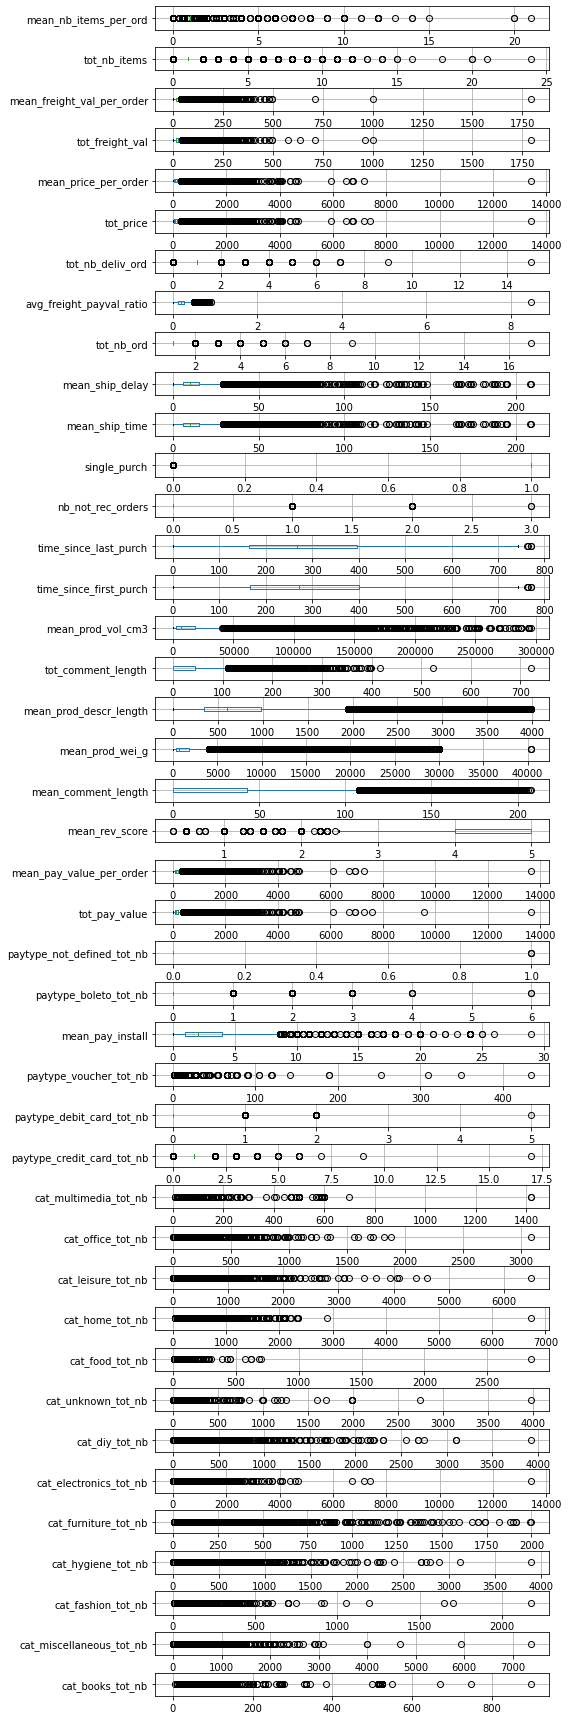

In [27]:
fig, axs = plt.subplots(len(df_cust[Q_cols].columns),1,
                        figsize=(8, 24), sharey=False)
for c, ax in zip(df_cust[Q_cols].columns, axs):
    df_cust.boxplot(c, vert=False, ax=ax)
fig.tight_layout(h_pad=0.051)
plt.show()

#### Histograms

Plotting histograms of the main quantitative continuous columns.

* Histograms of independant features

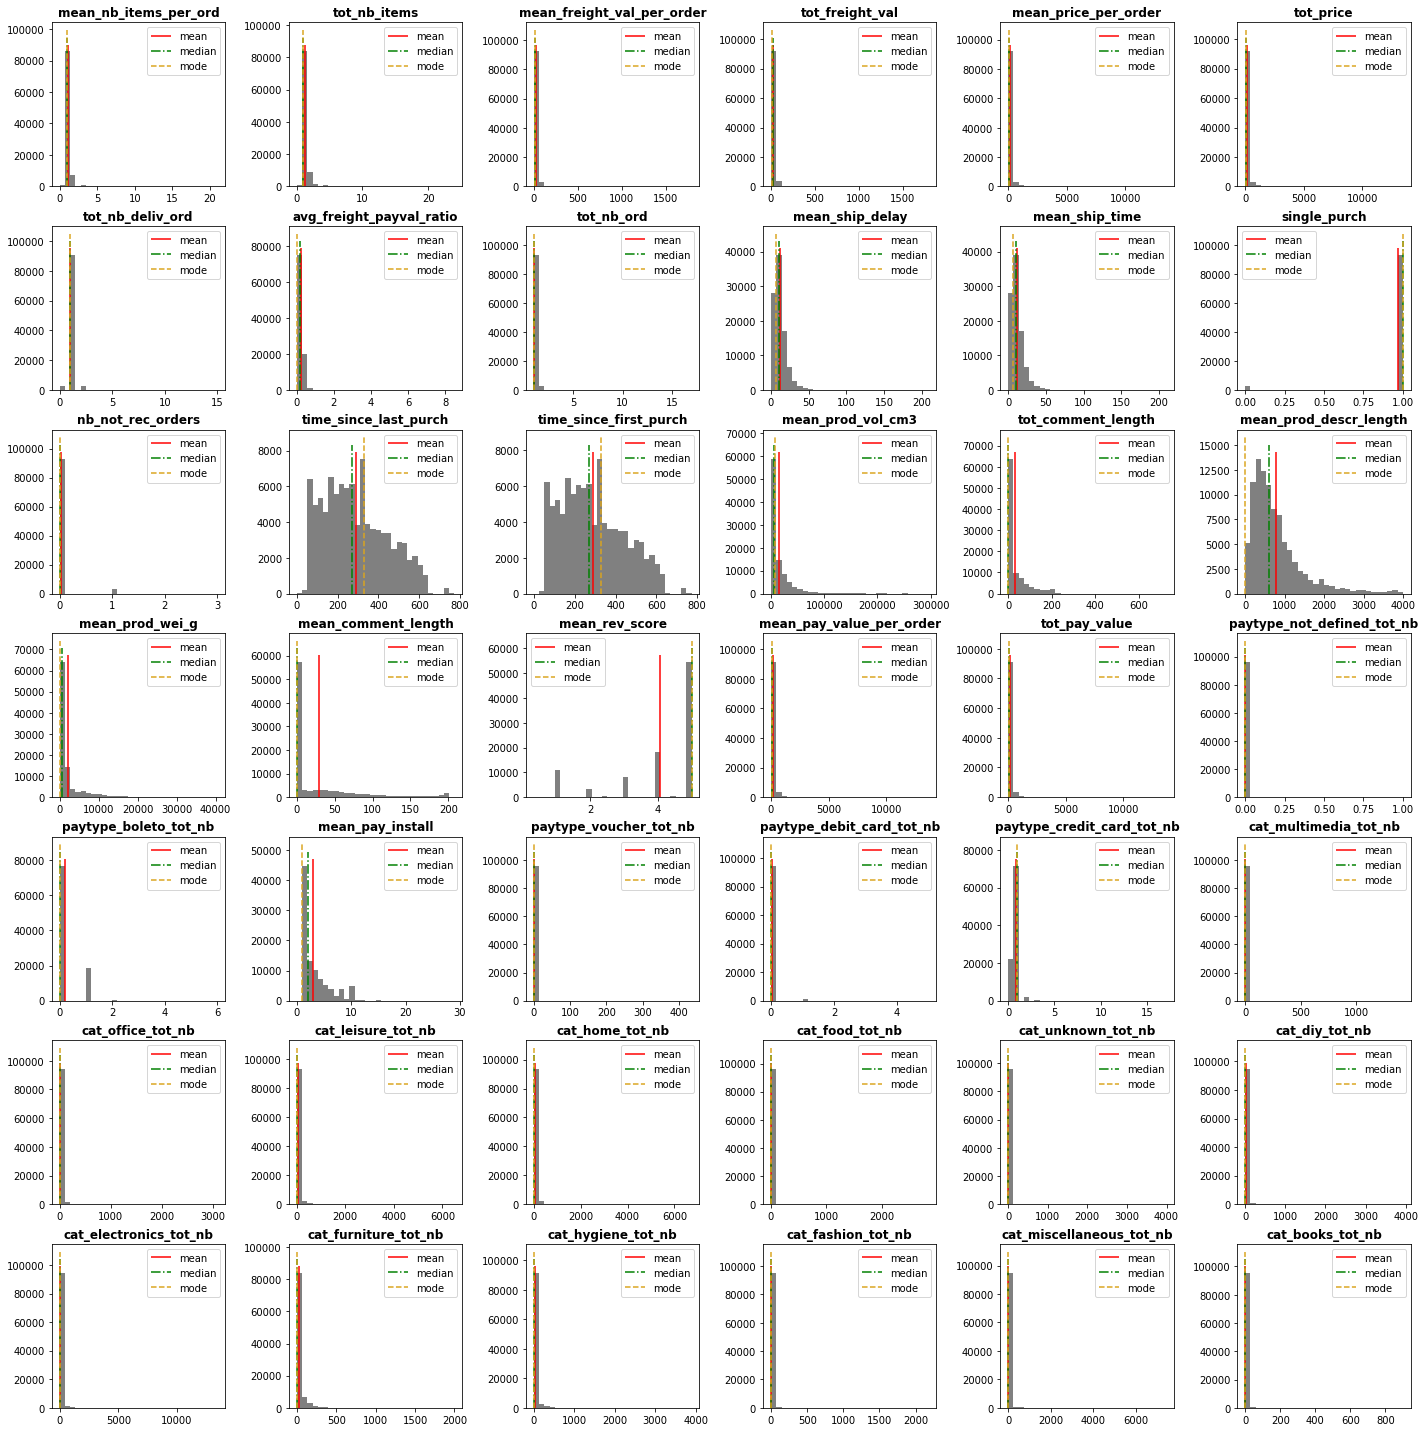

In [28]:
# All the data (with outliers)
plot_histograms(df=df_cust, cols=Q_cols,
                figsize=(20,20), bins=30, layout=(7,6), skip_outliers=False,
                thresh=3, save_enabled=False)

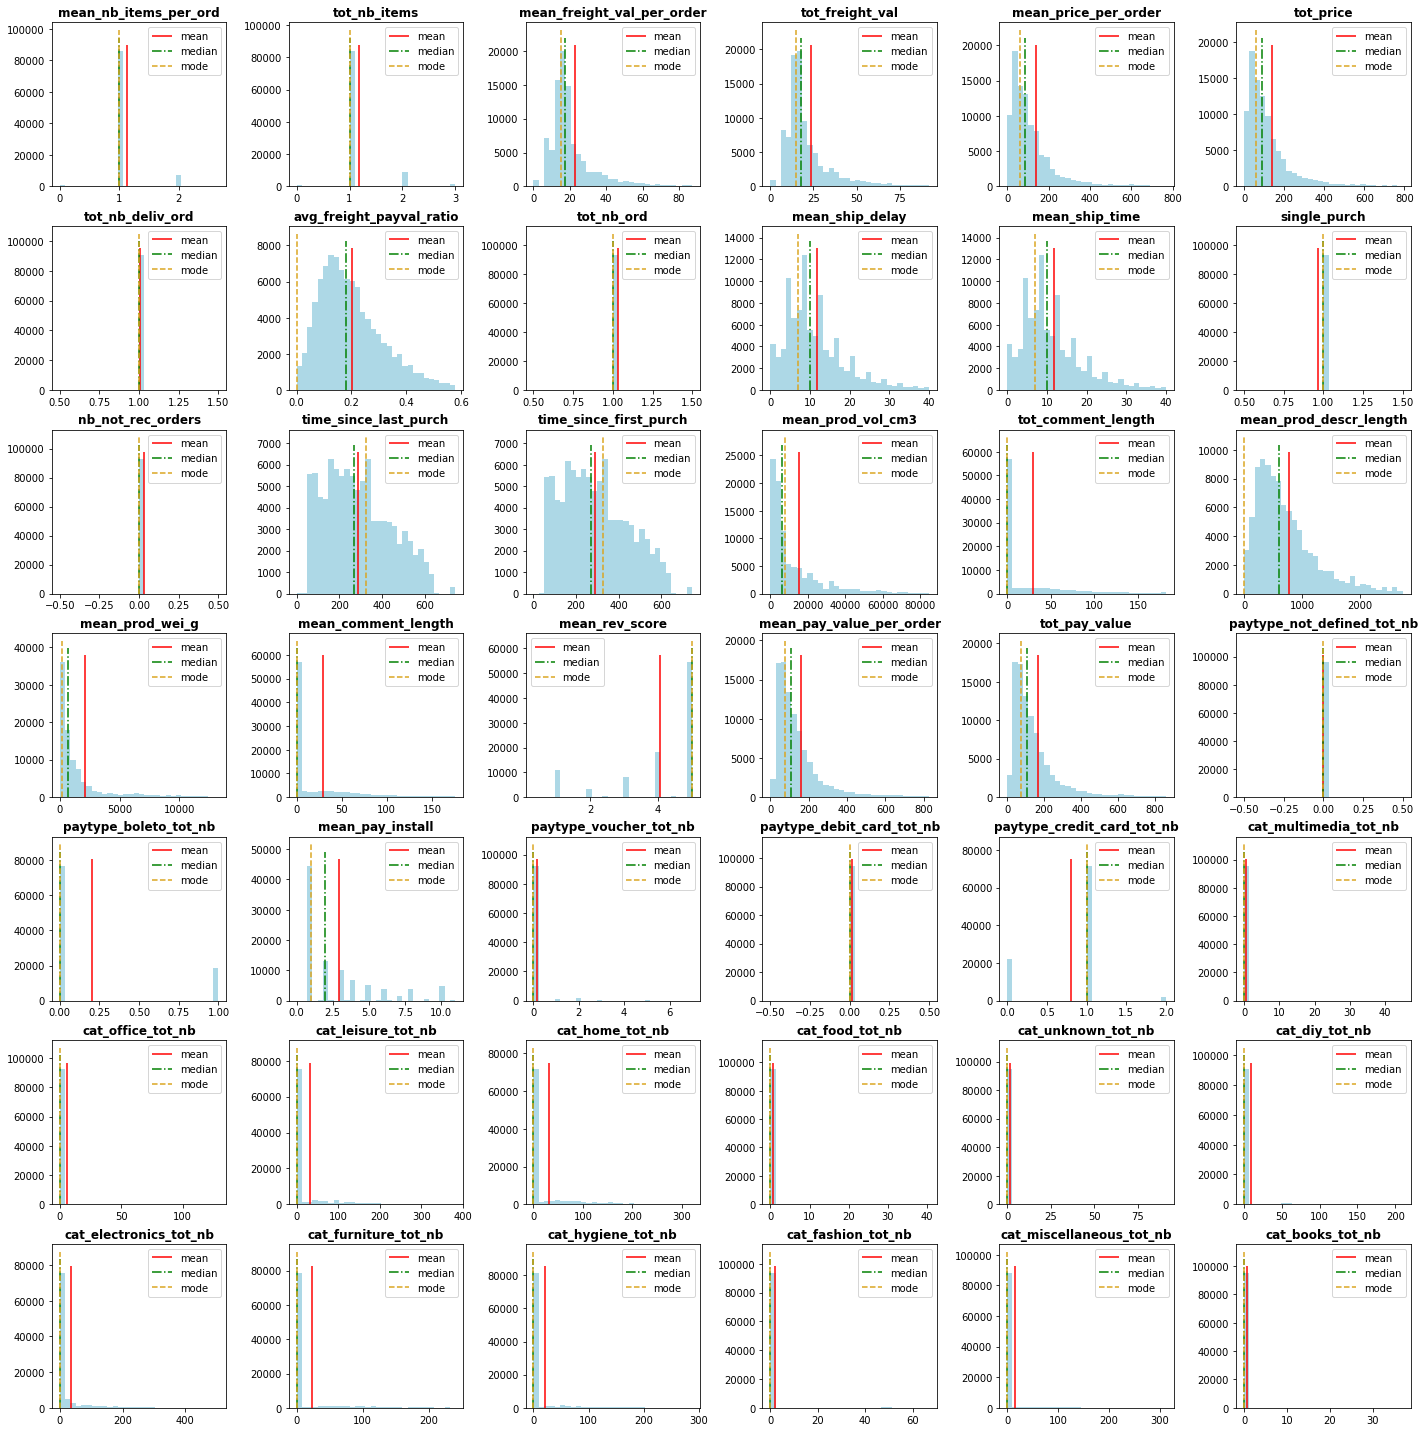

In [29]:
# Excluding outliers to get a better scale
plot_histograms(df=df_cust, cols=Q_cols, color = 'lightblue',
                figsize=(20,20), bins=30, layout=(7,6), skip_outliers=True,
                thresh=3, save_enabled=False)

#### Correlations

Linear correlation (Pearson)

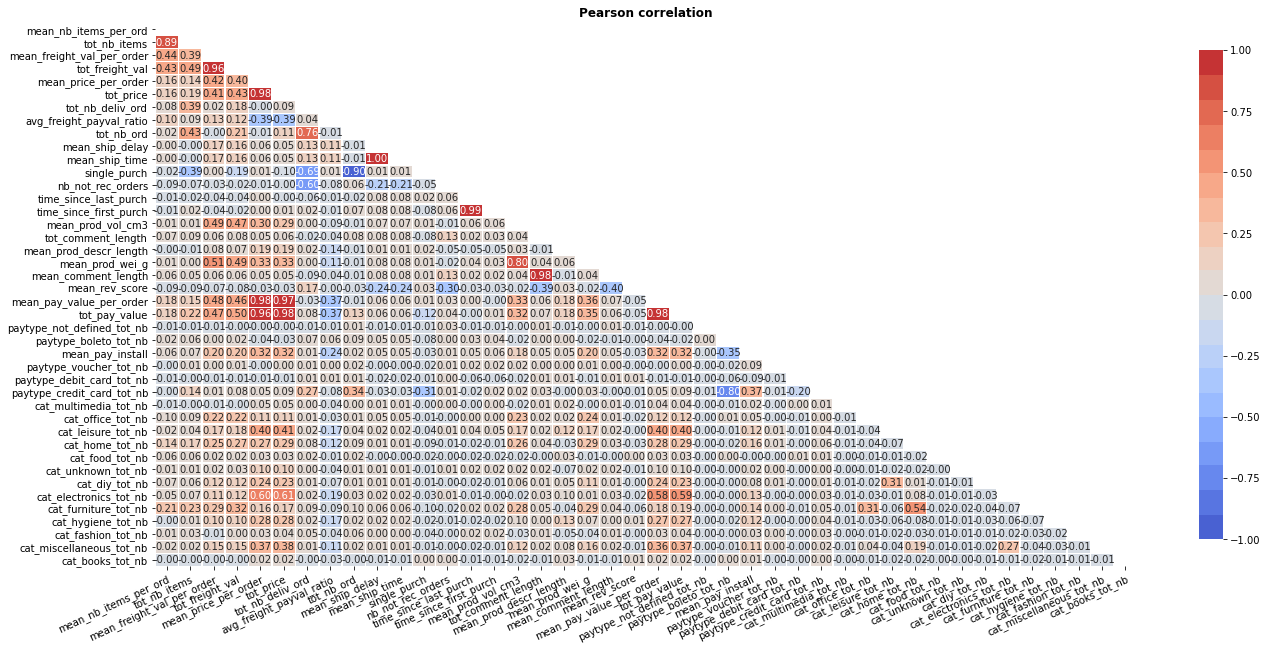

In [30]:
pears_corr = df_cust[Q_cols].corr()
plot_heatmap(pears_corr, shape='tri',
             title="Pearson correlation", figsize=(22,10))
plt.show()

#### PCA

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe', # Ordinal encoding for 'region'
                     strat_quant='stand') # Standardization for quantitative data
df_cust_trans = ct.fit_transform(df_cust)

# pca_cols = [c for c in df_cust.columns if not (('cat_' in c) or ('paytype' in c))]
pca_cols = df_cust_trans.columns
df_pca = df_cust_trans.loc[:, pca_cols]

n_comp = 20
pca = PCA(n_components=n_comp).fit(df_pca)

pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T

df_pca_proj = pd.DataFrame(pca.transform(df_pca),
                           columns=['PC'+str(i) for i in range(n_comp)])
df_pca_proj.head(3)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,0.09,0.31,-0.29,1.48,-1.87,-0.83,-1.18,-1.47,-0.50,0.71,-1.21,-1.15,0.87,0.19,-0.52,-0.06,-0.14,0.05,0.20,0.17
1,-2.05,0.52,1.29,-0.09,-0.92,0.07,-0.55,0.21,-0.04,0.03,0.42,0.05,-0.00,-0.11,-0.06,-0.16,-0.03,0.13,-0.02,-0.15
2,-0.17,-0.92,-1.40,-0.00,2.61,-2.43,0.23,0.72,-0.67,-0.08,-0.16,0.46,0.08,-0.56,0.34,0.52,-0.02,-0.09,0.23,-0.72


Plotting principal components

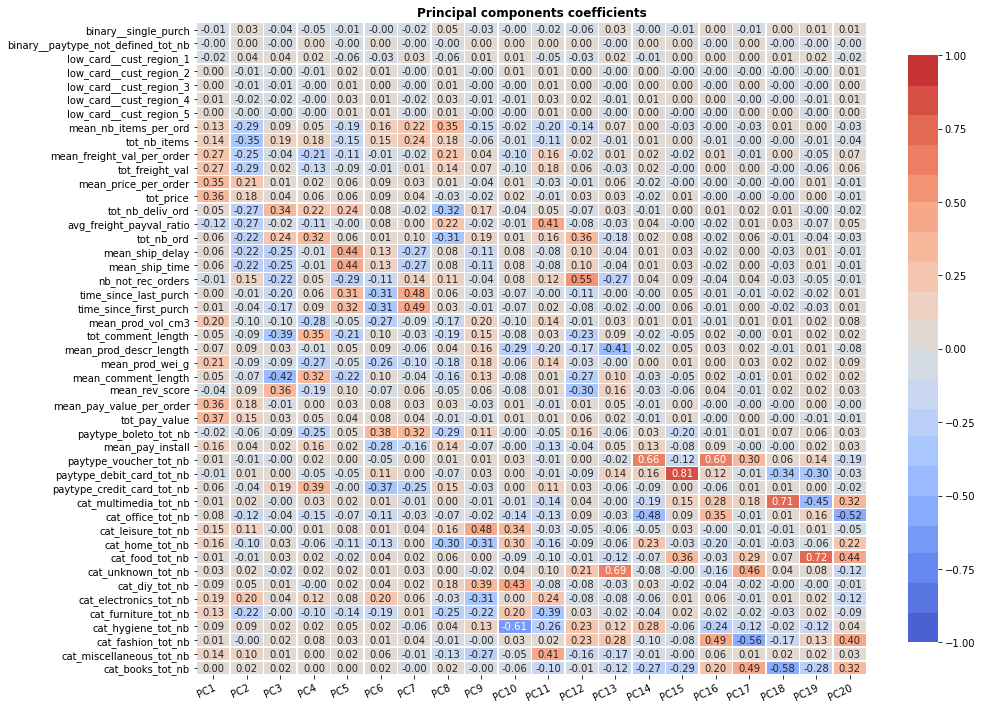

In [32]:
plot_heatmap(pca_df,'Principal components coefficients',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),
             figsize=(15,12),shape='rect')
plt.show()

Plotting explained variance ratio in scree plot

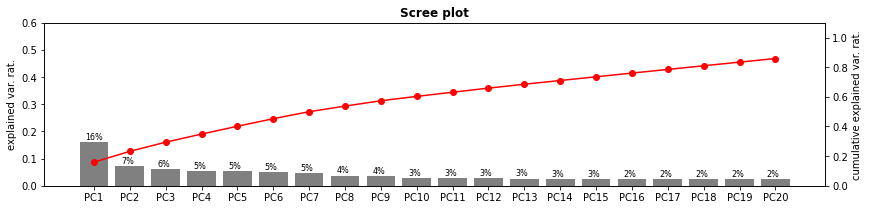

In [33]:
exp_var_rat = pca.explained_variance_ratio_
scree_plot(col_names= pca_df.columns, exp_var_rat=exp_var_rat,
           ylim=(0,0.6), figsize=(14,3))
plt.show()

First 20 principal components explain 80% of the variance of the data.

The PCA does not gather enough variance in the first components, it will be hard to use.

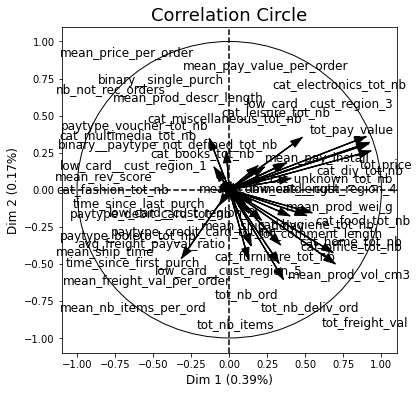

In [34]:
from mlxtend.plotting import plot_pca_correlation_graph # !pip install mlxtend==0.17.3

figure, correlation_matrix = \
     plot_pca_correlation_graph(X = df_cust_trans.values, variables_names = pca_cols,
                                dimensions=(1, 2), figure_axis_size=6,
                                X_pca = df_pca_proj.values[:,0:2],
                                explained_variance = exp_var_rat[0:2])
plt.show()

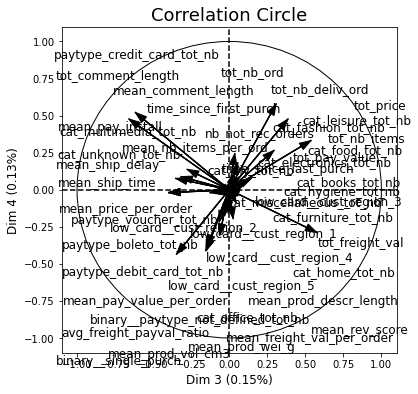

In [35]:
figure, correlation_matrix = \
     plot_pca_correlation_graph(X = df_cust_trans.values, variables_names = pca_cols,
                                dimensions=(3, 4), figure_axis_size=6,
                                X_pca = df_pca_proj.values[:,0:4],
                                explained_variance = exp_var_rat[0:4])
plt.show()

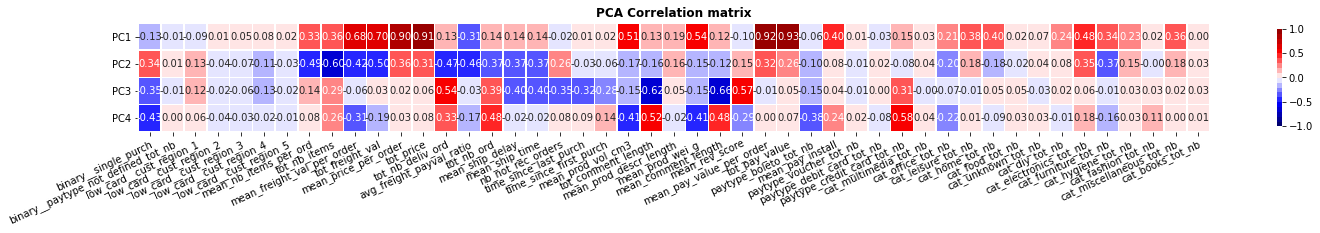

In [36]:
plot_heatmap(correlation_matrix.T,'PCA Correlation matrix',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("seismic", 20),
             figsize=(24,2),shape='rect')
plt.gca().set_yticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
plt.show()

### 2.2 Categorical data

In [37]:
C_cols = df_cust.select_dtypes(include=['object']).columns
C_cols

Index(['cust_region'], dtype='object')

#### Bar plots

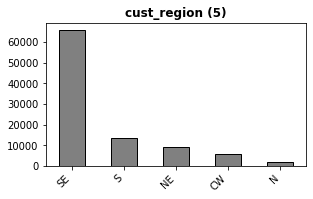

In [38]:
plot_barplots(df=df_cust, cols=C_cols, figsize=(12,10), layout=(4,3))
plt.show()

In [39]:
speak("data exploration: done")

## 3 Exportation of the Customers dataset

Now we export the dataset of aggregated orders in a .csv file.

In [40]:
df_cust.head()

,cust_region,mean_nb_items_per_ord,tot_nb_items,mean_freight_val_per_order,tot_freight_val,mean_price_per_order,tot_price,tot_nb_deliv_ord,avg_freight_payval_ratio,tot_nb_ord,mean_ship_delay,mean_ship_time,single_purch,nb_not_rec_orders,time_since_last_purch,time_since_first_purch,mean_prod_vol_cm3,tot_comment_length,mean_prod_descr_length,mean_prod_wei_g,mean_comment_length,mean_rev_score,mean_pay_value_per_order,tot_pay_value,paytype_not_defined_tot_nb,paytype_boleto_tot_nb,mean_pay_install,paytype_voucher_tot_nb,paytype_debit_card_tot_nb,paytype_credit_card_tot_nb,cat_multimedia_tot_nb,cat_office_tot_nb,cat_leisure_tot_nb,cat_home_tot_nb,cat_food_tot_nb,cat_unknown_tot_nb,cat_diy_tot_nb,cat_electronics_tot_nb,cat_furniture_tot_nb,cat_hygiene_tot_nb,cat_fashion_tot_nb,cat_miscellaneous_tot_nb,cat_books_tot_nb
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,SE,1.00,1.00,12.00,12.00,129.90,129.90,1,0.08,1,6,6,1,0,160,160,7616.00,111.00,236.00,1500.00,111.00,5.00,141.90,141.90,0.00,0.00,8.00,0.00,0.00,1.00,0.00,0.00,0.00,129.90,0.00,0.00,0.00,0.00,129.90,0.00,0.00,0.00,0.00
0000b849f77a49e4a4ce2b2a4ca5be3f,SE,1.00,1.00,8.29,8.29,18.90,18.90,1,0.29,1,3,3,1,0,163,163,5148.00,0.00,635.00,375.00,0.00,4.00,27.19,27.19,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.90,0.00,0.00,0.00
0000f46a3911fa3c0805444483337064,S,1.00,1.00,17.22,17.22,69.00,69.00,1,0.20,1,25,25,1,0,585,585,43750.00,0.00,177.00,1500.00,0.00,3.00,86.22,86.22,0.00,0.00,8.00,0.00,0.00,1.00,0.00,69.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0000f6ccb0745a6a4b88665a16c9f078,N,1.00,1.00,17.63,17.63,25.99,25.99,1,0.40,1,20,20,1,0,369,369,1045.00,12.00,1741.00,150.00,12.00,4.00,43.62,43.62,0.00,0.00,4.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.99,0.00,0.00,0.00,0.00,0.00
0004aac84e0df4da2b147fca70cf8255,SE,1.00,1.00,16.89,16.89,180.00,180.00,1,0.09,1,13,13,1,0,336,336,528.00,0.00,794.00,6050.00,0.00,5.00,196.89,196.89,0.00,0.00,6.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,180.00,0.00,0.00,0.00,0.00,0.00


In [41]:
df_cust.reset_index().to_csv('agg_customers.csv')

In [42]:
speak('exportation of cleaned data: done')